In [1]:
import time
start = time.perf_counter()

In [8]:
import time
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.mixture import GaussianMixture
from sklearn import preprocessing
from sklearn.decomposition import PCA, FactorAnalysis, FastICA
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, auc, confusion_matrix, roc_curve, roc_auc_score, recall_score, f1_score, classification_report, precision_score, homogeneity_score, normalized_mutual_info_score, davies_bouldin_score, mean_squared_error, adjusted_rand_score, adjusted_mutual_info_score, silhouette_score
from kmodes.kmodes import KModes

In [9]:
np.random.seed(903967645)

In [10]:
phishing_dataset = pd.read_csv('../data/phishing_dataset.csv')
print(phishing_dataset.info())
phishing_dataset.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11055 entries, 0 to 11054
Data columns (total 32 columns):
 #   Column                       Non-Null Count  Dtype
---  ------                       --------------  -----
 0   index                        11055 non-null  int64
 1   having_IPhaving_IP_Address   11055 non-null  int64
 2   URLURL_Length                11055 non-null  int64
 3   Shortining_Service           11055 non-null  int64
 4   having_At_Symbol             11055 non-null  int64
 5   double_slash_redirecting     11055 non-null  int64
 6   Prefix_Suffix                11055 non-null  int64
 7   having_Sub_Domain            11055 non-null  int64
 8   SSLfinal_State               11055 non-null  int64
 9   Domain_registeration_length  11055 non-null  int64
 10  Favicon                      11055 non-null  int64
 11  port                         11055 non-null  int64
 12  HTTPS_token                  11055 non-null  int64
 13  Request_URL                  11055 non-null  i

,index,having_IPhaving_IP_Address,URLURL_Length,Shortining_Service,having_At_Symbol,double_slash_redirecting,Prefix_Suffix,having_Sub_Domain,SSLfinal_State,Domain_registeration_length,...,popUpWidnow,Iframe,age_of_domain,DNSRecord,web_traffic,Page_Rank,Google_Index,Links_pointing_to_page,Statistical_report,Result
0,1,-1,1,1,1,-1,-1,-1,-1,-1,...,1,1,-1,-1,-1,-1,1,1,-1,-1
1,2,1,1,1,1,1,-1,0,1,-1,...,1,1,-1,-1,0,-1,1,1,1,-1
2,3,1,0,1,1,1,-1,-1,-1,-1,...,1,1,1,-1,1,-1,1,0,-1,-1
3,4,1,0,1,1,1,-1,-1,-1,1,...,1,1,-1,-1,1,-1,1,-1,1,-1
4,5,1,0,-1,1,1,-1,1,1,-1,...,-1,1,-1,-1,0,-1,1,1,1,1


In [11]:
# Check shape of dataset and for null data
print(phishing_dataset.shape)
phishing_dataset.isna().any().any()

(11055, 32)


False

In [12]:
phishing_dataset = phishing_dataset.sample(frac=0.1, random_state=42)

# Separate features and target
train_X = phishing_dataset.drop(columns=['Result', 'Favicon', 'Shortining_Service', 'popUpWidnow', 'double_slash_redirecting'])
train_y = phishing_dataset['Result']

# Normalize the feature data
min_max_scaler = preprocessing.MinMaxScaler()
X_scaled = min_max_scaler.fit_transform(train_X)

# Convert back to DataFrame
train_X = pd.DataFrame(X_scaled, columns=train_X.columns)
print(train_X.shape)

(1106, 27)


In [13]:
dims = list(range(2, 28, 1))

2 :  0.23852828795178072 0.5425876816526771
3 :  0.3274049932101513 0.5295904439192459
4 :  0.40619933017225823 0.5180670184123272
5 :  0.4762623471919397 0.507815543173066
6 :  0.5383908907587461 0.49873594275708966
7 :  0.5863779364172903 0.4917178925097242
8 :  0.6317328194410421 0.48508585568083995
9 :  0.6725404412324961 0.4791181297810728
10 :  0.7097904895321224 0.47367102361354
11 :  0.7427586366273491 0.4688495384238833
12 :  0.7729944979538809 0.46442803402961774
13 :  0.8012408511164653 0.4602973570596858
14 :  0.8286796442294736 0.4562843239866904
15 :  0.853698205248282 0.4526259886578006
16 :  0.8738215820995094 0.4496834668850429
17 :  0.892838181195089 0.44690251837930184
18 :  0.9097873965601435 0.4444238940202481
19 :  0.9245184173347377 0.44226965465640583
20 :  0.9386287744525416 0.44020618008759177
21 :  0.9521082036625867 0.4382349713403687
22 :  0.963958613987884 0.43650198753761266
23 :  0.9740575859331411 0.4350251310976072
24 :  0.9828084392474444 0.4337454212

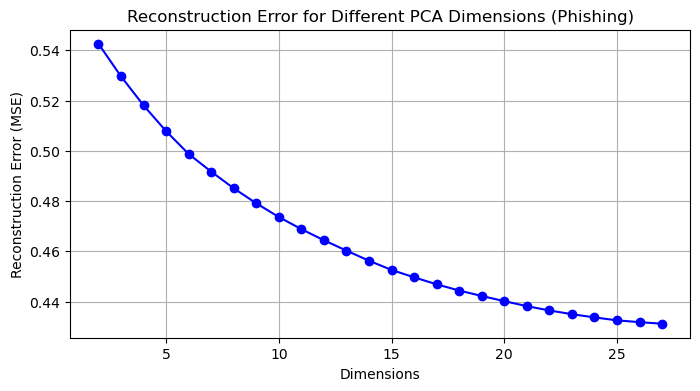

CPU times: user 4min 50s, sys: 15.5 s, total: 5min 5s
Wall time: 58.1 s


In [15]:
%%time
explained_variance_ratios = []
reconstruction_errors = []

for dim in dims:
    pca = PCA(n_components=dim, random_state=42)
    pca.fit(train_X.values)
    
    # PCA transformation
    x_prime = pca.transform(train_X.values)
    
    # Reconstruction
    A = np.linalg.pinv(pca.components_.T)
    reconstructed = np.dot(x_prime, A)
    rc_err = mean_squared_error(train_X.values, reconstructed)    
    
    explained_variance_ratios.append(sum(pca.explained_variance_ratio_))
    reconstruction_errors.append(rc_err)
    
    print(dim, ": ", sum(pca.explained_variance_ratio_), rc_err)

# Plotting reconstruction errors
plt.figure(figsize=(8, 4))
plt.plot(dims, reconstruction_errors, marker='o', linestyle='-', color='b')
plt.xlabel("Dimensions")
plt.ylabel("Reconstruction Error (MSE)")
plt.title("Reconstruction Error for Different PCA Dimensions (Phishing)")
plt.grid(True)
plt.savefig('../images/phishing-pca-rmse.png')
plt.show()

In [10]:
%%time
comp = 5
pca = PCA(n_components=comp, random_state=42)
pca_result = pca.fit_transform(train_X.values)
for i in range(comp):
    field_name = "pca-"+str(i)
    train_X[field_name] = pca_result[:,i]
    phishing_dataset[field_name] = pca_result[:,i]
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))
sum(pca.explained_variance_ratio_)
train_X_pca = pca_result

Explained variation per principal component: [0.14725521 0.12593709 0.10418194 0.06960958 0.06214713]
CPU times: user 5.85 s, sys: 1.58 s, total: 7.42 s
Wall time: 798 ms


In [11]:
train_X.head()

,index,having_IPhaving_IP_Address,URLURL_Length,Shortining_Service,having_At_Symbol,double_slash_redirecting,Prefix_Suffix,having_Sub_Domain,SSLfinal_State,Domain_registeration_length,...,web_traffic,Page_Rank,Google_Index,Links_pointing_to_page,Statistical_report,pca-0,pca-1,pca-2,pca-3,pca-4
0,0.957376,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.5,0.0,...,0.5,0.0,1.0,1.0,1.0,-0.466501,-0.240470,0.529845,0.481128,-0.009967
1,0.681448,0.0,0.0,1.0,1.0,1.0,0.0,0.5,0.0,0.0,...,1.0,0.0,1.0,0.0,1.0,-0.057339,-0.057391,0.058197,0.138408,0.972392
2,0.977647,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,...,0.5,1.0,0.0,1.0,1.0,-0.397860,0.123765,0.211624,0.885696,0.400505
3,0.270498,1.0,0.0,1.0,1.0,1.0,0.0,0.5,1.0,0.0,...,1.0,1.0,0.0,1.0,0.0,1.859748,-0.709930,-0.667138,-0.695173,0.080315
4,0.808778,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,...,1.0,0.0,0.0,0.5,1.0,-0.722140,-0.221174,0.063207,0.658838,-0.840772


In [9]:
# Plotting the first two PCA components
plt.figure(figsize=(8, 4))
sns.scatterplot(
    x='pca-0', y='pca-1',
    hue='Result',
    palette=sns.color_palette('tab10', 2),
    data=phishing_dataset,
    legend='full',
    alpha=0.3
)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('2D PCA Scatter Plot (Phishing)')
plt.savefig('../images/phishing-pca-2d.png')
plt.show()

ValueError: Could not interpret value `pca-0` for `x`. An entry with this name does not appear in `data`.

<Figure size 800x400 with 0 Axes>

KeyError: 'pca-0'

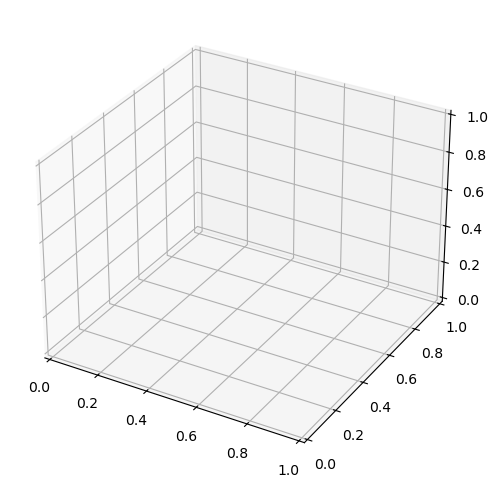

In [8]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(
    xs=phishing_dataset["pca-0"], 
    ys=phishing_dataset["pca-1"], 
    zs=phishing_dataset["pca-2"], 
    c=phishing_dataset["Result"], 
    cmap='tab10',
    alpha=0.3
)
ax.set_xlabel('PCA Component 1')
ax.set_ylabel('PCA Component 2')
ax.set_zlabel('PCA Component 3')
plt.colorbar(scatter, ax=ax, label='Result')
plt.title('3D PCA Scatter Plot (Phishing)')
plt.savefig('../images/phishing-pca-3d.png')
plt.show()

# Clustering

In [ ]:
%%time
davies_bouldin_scores_KM = {}
adjusted_rand_scores_KM = {}
homogeneity_scores_KM = {}

for cluster in range(2, 31, 1):
    kmodes = KModes(n_clusters=cluster, init='Huang', n_init=10, max_iter=50, random_state=42).fit(train_X_pca)
    label = kmodes.labels_
    
    # Calculate Davies-Bouldin Index
    db_score = davies_bouldin_score(train_X_pca, label)
    # Calculate Adjusted Rand Index
    ari_score = adjusted_rand_score(train_y, label)
    # Calculate Homogeneity Score
    homog_score = homogeneity_score(train_y, label)
    
    davies_bouldin_scores_KM[cluster] = db_score
    adjusted_rand_scores_KM[cluster] = ari_score
    homogeneity_scores_KM[cluster] = homog_score
    
    print(f"For n_clusters={cluster}, The Davies-Bouldin Index is {db_score}")
    print(f"For n_clusters={cluster}, The Adjusted Rand Index is {ari_score}")
    print(f"For n_clusters={cluster}, The homogeneity_score is {homog_score}")

# Plotting Davies-Bouldin Index
plt.figure(figsize=(10, 6))
plt.plot(list(davies_bouldin_scores_KM.keys()), list(davies_bouldin_scores_KM.values()), marker='o')
plt.xlabel("Number of Clusters")
plt.ylabel("Davies-Bouldin Index")
plt.title("K-Modes - Davies-Bouldin Index for Various Numbers of Clusters - PCA (Phishing)")
plt.grid(True)
plt.savefig('../images/phishing-pca-kmodes-davies-bouldin-index.png')
plt.show()

In [ ]:
# Plotting Adjusted Rand Index
plt.figure(figsize=(8, 4))
plt.plot(list(adjusted_rand_scores_KM.keys()), list(adjusted_rand_scores_KM.values()), marker='o', color='g')
plt.xlabel("Number of Clusters")
plt.ylabel("Adjusted Rand Index")
plt.title("K-Modes - Adjusted Rand Index for Various Numbers of Clusters - PCA (Phishing)")
plt.grid(True)
plt.savefig('../images/phishing-pca-kmodes-adjusted-rand-index.png')
plt.show()

In [ ]:
# Plotting Davies-Bouldin Index, Adjusted Rand Index, and Homogeneity Score together
plt.figure(figsize=(8, 4))
plt.plot(list(davies_bouldin_scores_KM.keys()), list(davies_bouldin_scores_KM.values()), 'b', label='Davies-Bouldin Index', marker='o')
plt.plot(list(adjusted_rand_scores_KM.keys()), list(adjusted_rand_scores_KM.values()), 'g', label='Adjusted Rand Index', marker='x')
plt.plot(list(homogeneity_scores_KM.keys()), list(homogeneity_scores_KM.values()), 'r', label='Homogeneity Score', marker='^')
plt.legend(loc='best')
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('K-Modes - Silhouette Coefficient and Homogeneity Score for Various Numbers of Clusters - PCA (Phishing)')
plt.grid(True)
plt.savefig('../images/phishing-pca-kmodes-silhouette-and-homogeneity.png')
plt.show()

In [ ]:
%%time
silhouette_coeffs_EM = {}
homogeneity_scores_EM = {}
log_likelihoood_EM = {}

for cluster in range(2, 16, 1):
    gmm = GaussianMixture(n_components=cluster, n_init=10, max_iter=25, random_state=42).fit(train_X_pca)
    label = gmm.predict(train_X_pca)
    sil_coeff = silhouette_score(train_X_pca, label, metric='euclidean')
    homog_score = homogeneity_score(train_y, label)
    silhouette_coeffs_EM[cluster] = sil_coeff
    homogeneity_scores_EM[cluster] = homog_score
    log_likelihood_EM[cluster] = gmm.score(train_X_pca)
    print(f"For n_clusters={cluster}, The Silhouette Coefficient is {sil_coeff}")
    print(f"For n_clusters={cluster}, The homogeneity_score is {homog_score}")
    print(f"For n_clusters={cluster}, The log_likeliehood score is {log_likelihood_EM[cluster]}")

    
# Plotting Silhouette Coefficients
plt.figure(figsize=(8, 4))
plt.plot(list(silhouette_coeffs_EM.keys()), list(silhouette_coeffs_EM.values()), marker='o')
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.title("Expectation Mazimization - Silhouette Coefficient for Various Numbers of Clusters - PCA (Phishing)")
plt.grid(True)
plt.savefig('../images/phishing-pca-em-silhouette-coefficients.png')
plt.show()

In [ ]:
# Plotting Silhouette Coefficient and Homogeneity Score
plt.figure(figsize=(10, 6))
plt.plot(list(silhouette_coeffs_EM.keys()), list(silhouette_coeffs_EM.values()), 'b', label='Silhouette Coefficient', marker='o')
plt.plot(list(homogeneity_scores_EM.keys()), list(homogeneity_scores_EM.values()), 'r', label='Homogeneity Score', marker='x')
plt.legend(loc='best')
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Expectation Maximization - Silhouette Coefficient and Homogeneity Score for Various Numbers of Clusters - PCA (Phishing)')
plt.grid(True)
plt.savefig('../images/phishing-pca-em-silhouette-homogeneity.png')
plt.show()

In [12]:
kmodes = KModes(n_clusters=5, random_state=42)
kmodes.fit(train_X_pca)
kmodes_labels = kmodes.labels_

In [13]:
train_X['KModes_Cluster'] = kmodes_labels

In [14]:
gmm = GaussianMixture(n_components=5, random_state=42)
gmm.fit(train_X_pca)
gmm_labels = gmm.predict(train_X_pca)

In [15]:
train_X['GMM_Cluster'] = gmm_labels
print(train_X.head())

      index  having_IPhaving_IP_Address  URLURL_Length  Shortining_Service  \
0  0.957376                         0.0            0.0                 1.0   
1  0.681448                         0.0            0.0                 1.0   
2  0.977647                         0.0            1.0                 1.0   
3  0.270498                         1.0            0.0                 1.0   
4  0.808778                         1.0            0.0                 1.0   

   having_At_Symbol  double_slash_redirecting  Prefix_Suffix  \
0               1.0                       1.0            0.0   
1               1.0                       1.0            0.0   
2               1.0                       1.0            0.0   
3               1.0                       1.0            0.0   
4               1.0                       1.0            0.0   

   having_Sub_Domain  SSLfinal_State  Domain_registeration_length  ...  \
0                0.0             0.5                          0.0  ...  

In [16]:
features_to_plot = ['pca-0', 'pca-1']
# Get unique clusters for KMeans and GMM
unique_clusters_kmodes = np.unique(train_X['KModes_Cluster'])
unique_clusters_gmm = np.unique(train_X['GMM_Cluster'])

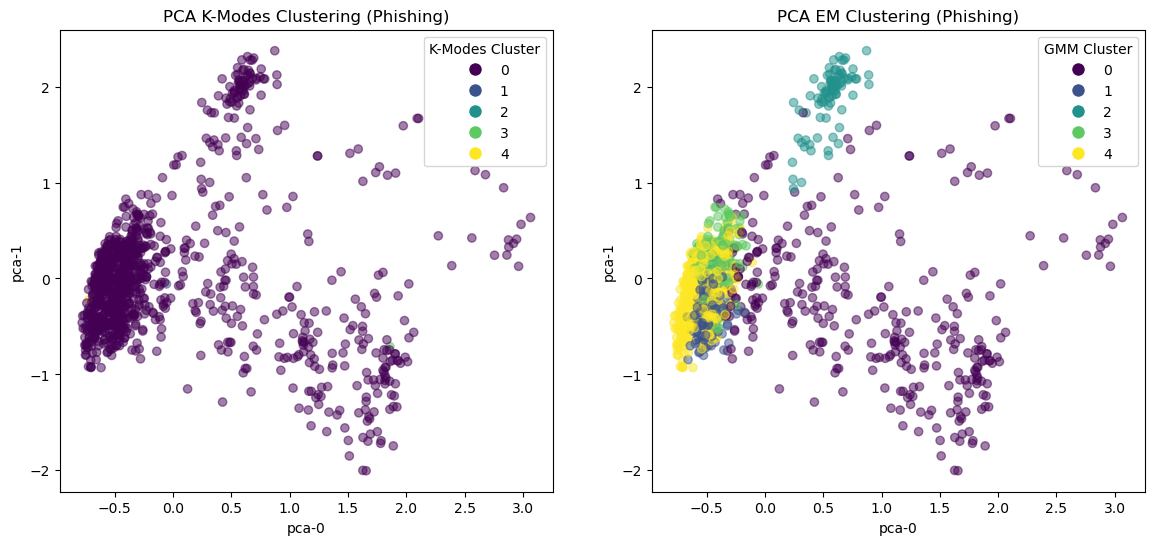

In [18]:
# Create a figure with subplots
plt.figure(figsize=(14, 6))

# Plot K-Means clustering results
plt.subplot(1, 2, 1)
scatter_kmodes = plt.scatter(train_X[features_to_plot[0]], train_X[features_to_plot[1]], c=train_X['KModes_Cluster'], cmap='viridis', alpha=0.5)
plt.title('PCA K-Modes Clustering (Phishing)')
plt.xlabel(features_to_plot[0])
plt.ylabel(features_to_plot[1])
handles_kmodes = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=scatter_kmodes.cmap(scatter_kmodes.norm(cluster)), markersize=10) for cluster in unique_clusters_kmodes]
plt.legend(handles_kmodes, unique_clusters_kmodes, title='K-Modes Cluster', loc='best')

# Plot GMM clustering results
plt.subplot(1, 2, 2)
scatter_gmm = plt.scatter(train_X[features_to_plot[0]], train_X[features_to_plot[1]], c=train_X['GMM_Cluster'], cmap='viridis', alpha=0.5)
plt.title('PCA EM Clustering (Phishing)')
plt.xlabel(features_to_plot[0])
plt.ylabel(features_to_plot[1])
handles_gmm = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=scatter_gmm.cmap(scatter_gmm.norm(cluster)), markersize=10) for cluster in unique_clusters_gmm]
plt.legend(handles_gmm, unique_clusters_gmm, title='GMM Cluster', loc='best')

# Save the plot
plt.savefig('../images/phishing-pca-clustering-comparison.png')

# Show the plot
plt.show()

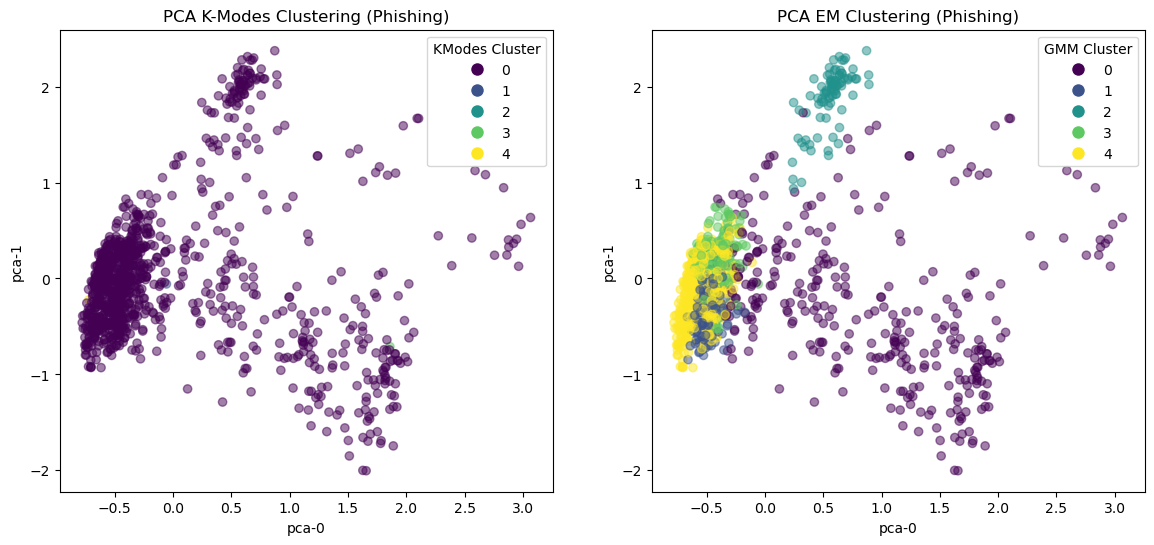

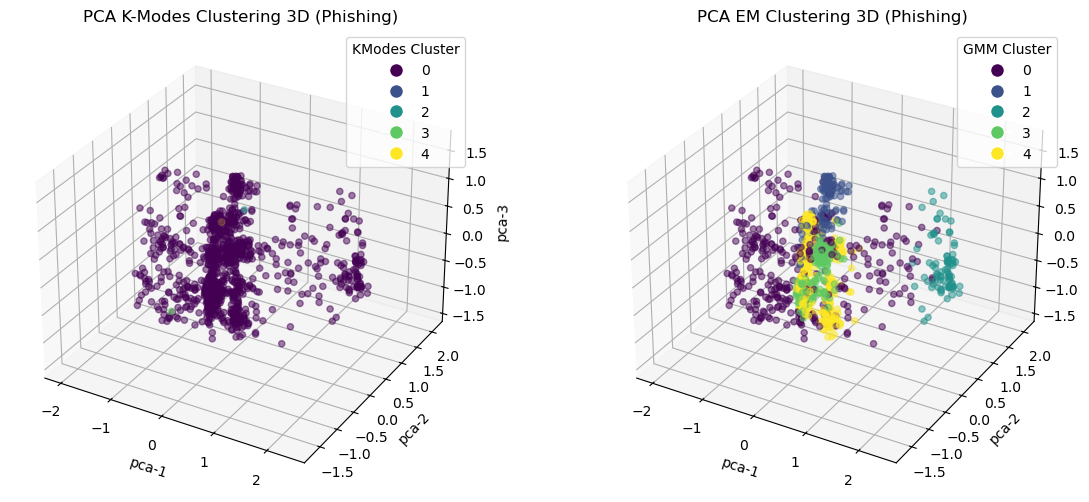

In [20]:
# Define the features you want to plot in 3D
features_to_plot_3d = ['pca-1', 'pca-2', 'pca-3']

# Create a figure for 2D K-Modes and EM clustering results
fig_2d = plt.figure(figsize=(14, 6))

# 2D Plot for K-Modes clustering results
ax1 = fig_2d.add_subplot(121)
scatter_kmodes = ax1.scatter(train_X[features_to_plot[0]], train_X[features_to_plot[1]], c=train_X['KModes_Cluster'], cmap='viridis', alpha=0.5)
ax1.set_title('PCA K-Modes Clustering (Phishing)')
ax1.set_xlabel(features_to_plot[0])
ax1.set_ylabel(features_to_plot[1])
handles_kmodes = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=scatter_kmodes.cmap(scatter_kmodes.norm(cluster)), markersize=10) for cluster in unique_clusters_kmodes]
ax1.legend(handles_kmodes, unique_clusters_kmodes, title='KModes Cluster', loc='best')

# 2D Plot for EM clustering results
ax2 = fig_2d.add_subplot(122)
scatter_gmm = ax2.scatter(train_X[features_to_plot[0]], train_X[features_to_plot[1]], c=train_X['GMM_Cluster'], cmap='viridis', alpha=0.5)
ax2.set_title('PCA EM Clustering (Phishing)')
ax2.set_xlabel(features_to_plot[0])
ax2.set_ylabel(features_to_plot[1])
handles_gmm = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=scatter_gmm.cmap(scatter_gmm.norm(cluster)), markersize=10) for cluster in unique_clusters_gmm]
ax2.legend(handles_gmm, unique_clusters_gmm, title='GMM Cluster', loc='best')

fig_2d.savefig('../images/phishing-comparison-pca-2D.png')
plt.show()

# Create a figure for 3D K-Modes and EM clustering results
fig_3d = plt.figure(figsize=(14, 6))

# 3D Plot for K-Modes clustering results
ax1 = fig_3d.add_subplot(121, projection='3d')
scatter_kmodes_3d = ax1.scatter(train_X[features_to_plot_3d[0]], train_X[features_to_plot_3d[1]], train_X[features_to_plot_3d[2]], c=train_X['KModes_Cluster'], cmap='viridis', alpha=0.5)
ax1.set_title('PCA K-Modes Clustering 3D (Phishing)')
ax1.set_xlabel(features_to_plot_3d[0])
ax1.set_ylabel(features_to_plot_3d[1])
ax1.set_zlabel(features_to_plot_3d[2], rotation=90)
ax1.legend(handles_kmodes, unique_clusters_kmodes, title='KModes Cluster', loc='best')

# 3D Plot for EM clustering results
ax2 = fig_3d.add_subplot(122, projection='3d')
scatter_gmm_3d = ax2.scatter(train_X[features_to_plot_3d[0]], train_X[features_to_plot_3d[1]], train_X[features_to_plot_3d[2]], c=train_X['GMM_Cluster'], cmap='viridis', alpha=0.5)
ax2.set_title('PCA EM Clustering 3D (Phishing)')
ax2.set_xlabel(features_to_plot_3d[0])
ax2.set_ylabel(features_to_plot_3d[1])
ax2.set_zlabel(features_to_plot_3d[2])
ax2.legend(handles_gmm, unique_clusters_gmm, title='GMM Cluster', loc='best')

fig_3d.savefig('../images/phishing-comparison-pca-3D.png')
plt.show()

In [24]:
# Calculate ARI
ari_score = adjusted_rand_score(train_X['KModes_Cluster'], train_X['GMM_Cluster'])
print(f'Phishing Dataset Adjusted Rand Index (ARI) between KMeans and GMM clusters PCA: {ari_score}')

# Calculate NMI
nmi_score = normalized_mutual_info_score(train_X['KModes_Cluster'], train_X['GMM_Cluster'])
print(f'Phishing Dataset Normalized Mutual Information (NMI) between KMeans and GMM clusters PCA: {nmi_score}')

Phishing Dataset Adjusted Rand Index (ARI) between KMeans and GMM clusters PCA: 0.0006042325608100081
Phishing Dataset Normalized Mutual Information (NMI) between KMeans and GMM clusters PCA: 0.007671104456171686


In [ ]:
end = time.perf_counter()
print("Time taken: in min", (end - start)/60)